# SYSID - Trabalho (ML - SISO.LM)

Alunos: 

Pedro Henrique Cardoso Paulo</br>
Felipe da Costa Pereira

Professor: Helon

## Objetivo

TBD

## Passo 0 - Importando bibliotecas

In [1]:
# Pacotes padrao
import os
import pickle
import copy
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime

#Pipeline
from sklearn.pipeline import Pipeline

#Tratamento
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

#Modelos
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.multioutput import MultiOutputRegressor

#sisidentpy
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial, Fourier
from sysidentpy.utils.narmax_tools import regressor_code

#Busca de modelos
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold

# Scores
from sklearn.metrics import r2_score

#Seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Disabling warnings
import warnings
from sklearn.exceptions import DataConversionWarning

#Definindo random_state
rs = 85

In [2]:
from sklearn_sid.regressors.sklearn import SYSIDRegressor
from sklearn_sid.preprocessors.fourrier_decompose import SFFTEnergyExpansor, SFFTFrequencyExpansor

## Passo 0 - Importando os dados

### 0.1 - Lendo dados

In [3]:
binary = os.path.join(os.getcwd(), 'data', 'volve_compiled.pkl')
print(binary)

with open(binary, 'rb') as bin_file:
    data = pickle.load(bin_file)

/mnt/d/Onedrive/Mestrado/gits/sklearn-sid/Volve-Dataset/data/volve_compiled.pkl


In [4]:
for wellp in data['OP'].keys():
    print(wellp)

15/9-F-1 C
15/9-F-11
15/9-F-12
15/9-F-14
15/9-F-15 D
15/9-F-5


### 0.2 - Visualizando dados

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


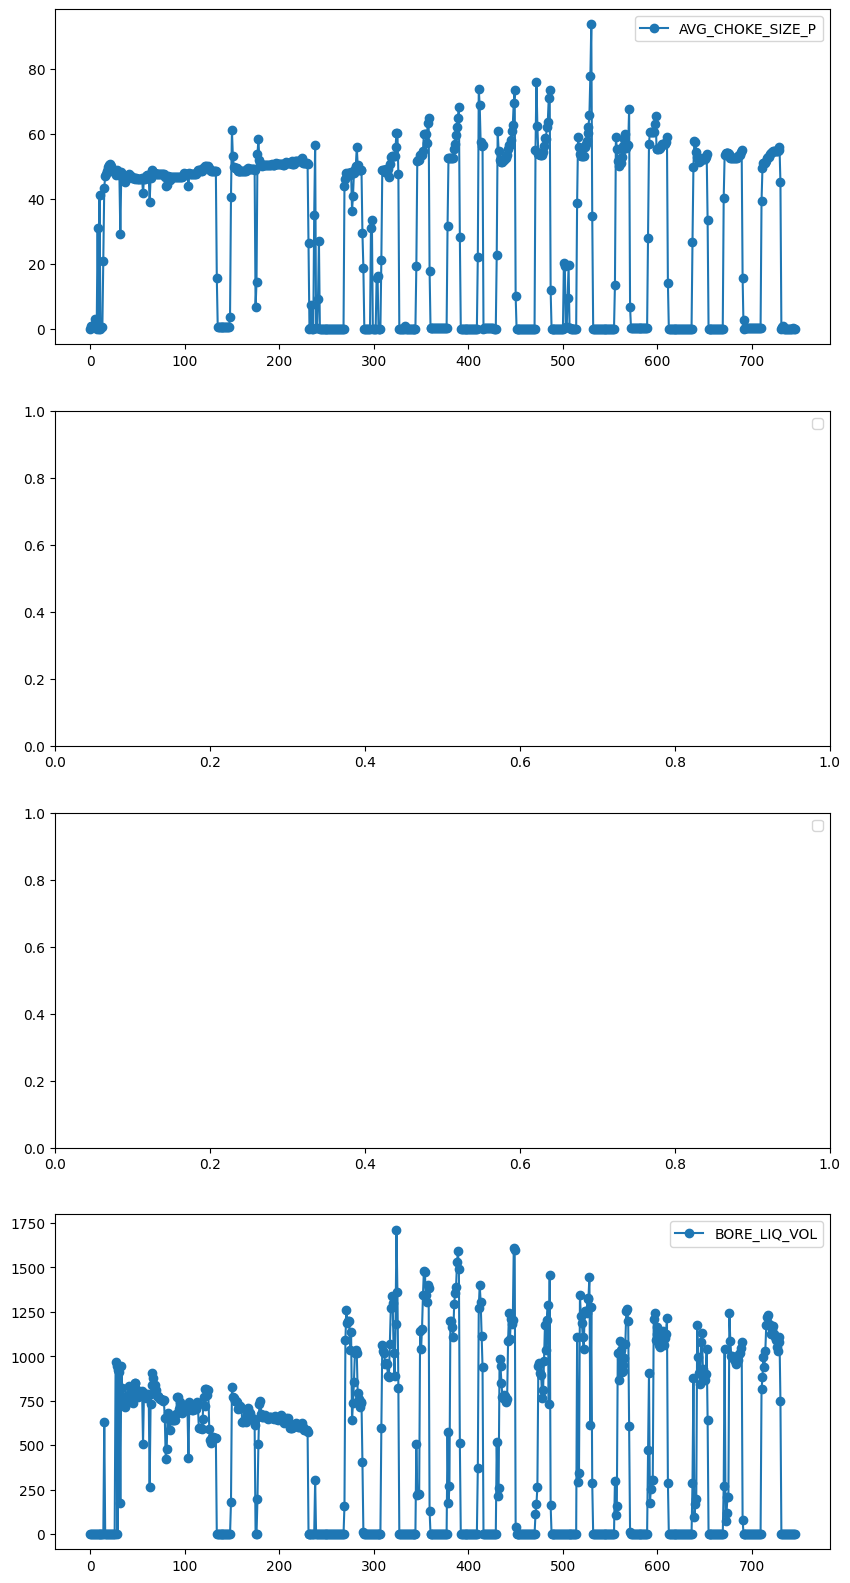

In [5]:
case = "15/9-F-1 C"
#case = "15/9-F-11"

data_case = data['OP'][case]

filt_vars_IN_Q =  [
        #'BORE_OIL_VOL',
        #'BORE_GAS_VOL',
        #'BORE_WAT_VOL',
        #'BORE_OIL_CUM',
        #'BORE_LIQ_CUM',
        #'BORE_GAS_CUM',
        #'BORE_WAT_CUM',
]

filt_vars_IN_QINJ = [
        'BORE_WI_VOL',
        'BORE_WI_CUM',
]

filt_vars_IN_P = [
        #'AVG_DOWNHOLE_PRESSURE',
        #'AVG_WHP_P',
        #'AVG_DP_TUBING',
        #'AVG_ANNULUS_PRESS',
        'AVG_CHOKE_SIZE_P',
        #'DP_CHOKE_SIZE',
]

filt_vars_IN_T = [
        #'AVG_WHT_P',
        #'AVG_DOWNHOLE_TEMPERATURE',
]

filt_vars_OUT = [
        #'BORE_OIL_VOL',
        'BORE_LIQ_VOL',
        #'BORE_GAS_VOL',
        #'BORE_WAT_VOL',
]

time = data_case['N']
fig, ax = plt.subplots(4,1, figsize=(10, 20))
for var in filt_vars_IN_P:
    ax[0].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_IN_Q:
    ax[1].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_IN_T:
    ax[2].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_OUT:
    ax[3].plot(time, data_case[var], '-o', label=var)
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

In [6]:
data_case = data_case.iloc[28:,:]
#data_case = data_case[data_case['AVG_DOWNHOLE_PRESSURE']>0]
data_case = data_case[filt_vars_IN_Q + filt_vars_IN_P + filt_vars_IN_T + filt_vars_OUT].dropna()
X1 = data_case[filt_vars_IN_Q + filt_vars_IN_P + filt_vars_IN_T].values
y =  data_case[filt_vars_OUT].values

## Passo 1 - Separando os dados em treino e teste

### 1.1 - Definindo a parcela de treino e de teste

In [7]:
p_train = 0.7 #70% treino

### 1.2 - Separando os conjuntos

In [8]:
n_train = int(X1.shape[0]*p_train)
X1_tr = X1[:n_train,:]
y_tr = y[:n_train,:]
X1_te = X1[:,:]
y_te = y[:,:]

In [9]:
print(
    X1_tr.shape,
    X1_te.shape
)

(502, 1) (718, 1)


### 1.3 - Removendo a escala 

In [10]:
X_scale = MinMaxScaler()
y_scale = MinMaxScaler()
X1_tr = X_scale.fit_transform(X1_tr)
X1_te = X_scale.transform(X1_te)
y_tr = y_scale.fit_transform(y_tr)
y_te = y_scale.transform(y_te)

### 1.4 - Decompondo a série

In [11]:
en = 2
fft_y = SFFTEnergyExpansor(energy_levels=en)
fft_X = SFFTEnergyExpansor(energy_levels=en)
y_tr_copy = y_tr.copy()
X1_tr_copy = X1_tr.copy()
y_tr = fft_y.fit_transform(y_tr)
y_te = fft_y.transform(y_te)
X1_tr = fft_X.fit_transform(X1_tr)
X1_te = fft_X.transform(X1_te)

In [12]:
print(
    X1_tr.shape,
    X1_te.shape
)

(502, 2) (718, 2)


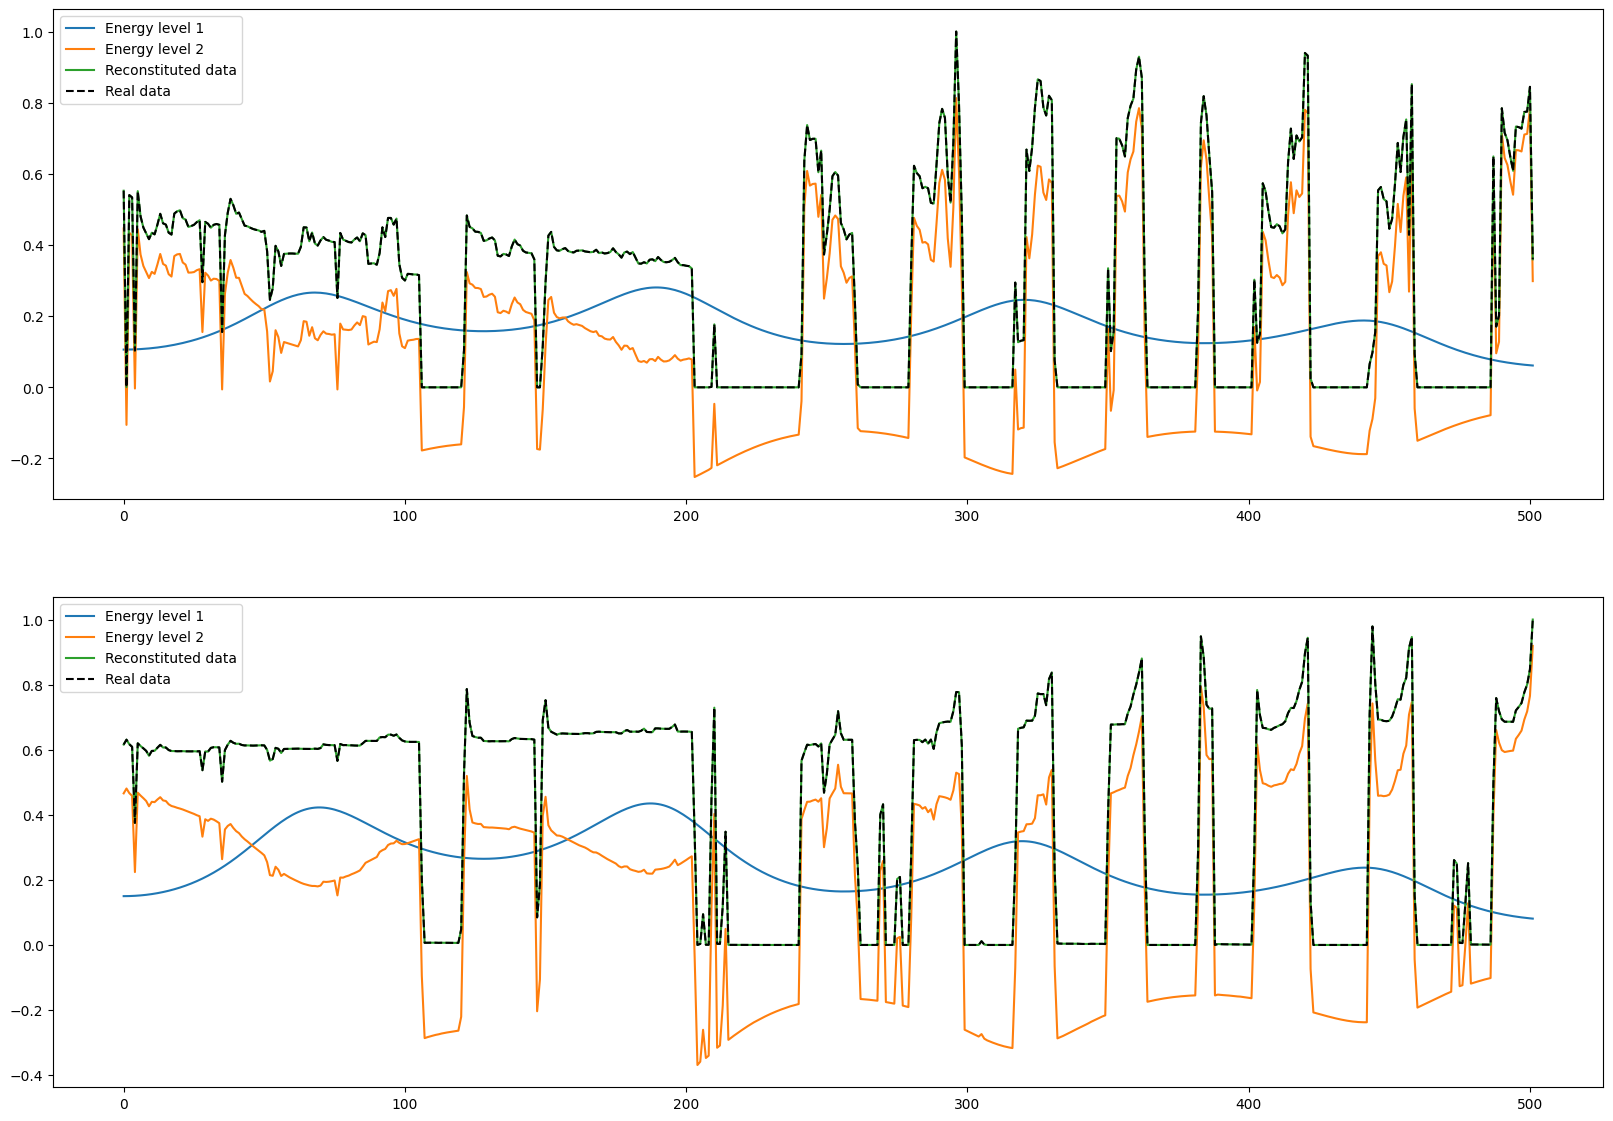

In [13]:
fig, ax = plt.subplots(2,1, figsize=(20,14))

for i in range(en):
    try:
        ax[0].plot(y_tr[:,i], label=f'Energy level {i+1}')
    except Exception:
        pass
    try:
        ax[1].plot(X1_tr[:,i], label=f'Energy level {i+1}')
    except Exception:
        pass
ax[0].plot(y_tr.sum(axis=1), label='Reconstituted data')
ax[1].plot(X1_tr.sum(axis=1), label='Reconstituted data')
ax[0].plot(y_tr_copy, 'k--', label='Real data')
ax[1].plot(X1_tr_copy, 'k--', label='Real data')
ax[0].legend()
ax[1].legend()


## Passo 2 - Declarando os modelos 

In [14]:
models = []

### 2.1 - ARMAX (sysidentpy)

### 2.2 - NARMAX (sysidentpy)

### 2.3 - Modelos de ML (sklearn)

#### 2.3.1 - Modelos

In [15]:
models_ml = [
    ('LinReg'          ,      LinearRegression(copy_X=True)), #ARX Equivalent
    ('PolyReg'         ,      Pipeline([('Poly', PolynomialFeatures(degree=2)), ('Reg', LinearRegression(copy_X=True))])), #NARX Equivalent
    ('SVM'             ,      SVR(max_iter=-1)),
    ('KNN'             ,      KNeighborsRegressor()),
    ('DecisionTree'    ,      DecisionTreeRegressor(random_state=rs)),
    ('RandomForest'    ,      RandomForestRegressor(random_state=rs)),
    ('GradientBoosting',      GradientBoostingRegressor(random_state=rs)),
    ('ExtraTrees'      ,      ExtraTreesRegressor(random_state=rs)),
    ('MLP'             ,      MLPRegressor(random_state=rs, )),
]

#### 2.3.2 - Parâmetros (RandomSearchCV)

In [16]:
parameters = [
    {
        #'PCA__n_components'           : stats.uniform(loc=0.7, scale=0.3),
        'positive'                     : [True, False],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'           : stats.uniform(loc=0.7, scale=0.3),
        'Reg__positive'                : [True, False],
        #'Poly__degree'                : [2, 3, 4, 5],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'C'                     : stats.loguniform(1e-3, 1e3),
        'kernel'                : ['poly', 'rbf', 'sigmoid','linear'],
        'degree'                : stats.randint(2,6),
        'gamma'                 : stats.loguniform(1e-4, 1e0),
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_neighbors'           : stats.randint(1,100),
        'weights'               : ['uniform', 'distance'],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        #'DT__criterion'              : ['gini', 'entropy'],
        'splitter'               : ['best', 'random'],
        'max_depth'              : stats.randint(5,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_estimators'           : stats.randint(5,100), #Numero de arvores
        #'RF__criterion'              : ['gini', 'entropy'],
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_estimators'           : stats.randint(5,100), #Numero de arvores
        'loss'                   : ['squared_error', 'absolute_error', 'huber', 'quantile'],
        'learning_rate'          : stats.loguniform(1e-5, 1e1),
        'criterion'              : ['friedman_mse', 'squared_error'],
        'subsample'              : stats.uniform(), 
        #'RF__criterion'              : ['gini', 'entropy'],
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_estimators'           : stats.randint(5,100), #Numero de arvores
        'criterion'              : ['squared_error', 'absolute_error'],
        #'RF__criterion'              : ['gini', 'entropy'],
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        'activation'            : ['relu'], #'logistic', 'tanh'],
        'early_stopping'        : [True, False],
        'alpha'                 : stats.loguniform(1e-4, 1e0),
        'hidden_layer_sizes'    : [] 
        + [n_neurons for n_neurons in itertools.product([20, 40, 60, 80, 100], repeat=1)]
        + [n_neurons for n_neurons in itertools.product([20, 40, 60, 80, 100], repeat=2)]
        + [n_neurons for n_neurons in itertools.product([20, 40, 60, 80, 100], repeat=3)]
        + [n_neurons for n_neurons in itertools.product([20, 40, 60, 80, 100], repeat=4)],
        'max_iter'              : [10000],#stats.randint(200,10000),
        'batch_size'            : [16, 32, 64, 128, 256],
        'solver'                : ['adam'], #'lbfgs'],
        'tol'                   : stats.loguniform(1e-7, 1e-1),

    },
]

In [17]:
kfolds = 5
niters = 10
rkf = RepeatedKFold(n_splits=kfolds, n_repeats=niters, random_state=71)

In [18]:
n_iter = 100 #Numero de iterações do rdmsearch 

for model, params in zip(models_ml, parameters):
    rdmsearch = RandomizedSearchCV(model[1], verbose=0, scoring='r2', 
                                   param_distributions=params, n_iter=n_iter, n_jobs=6, 
                                   cv=rkf, random_state=rs)
    
    if model[0] == 'MLP':
        sidmodel = SYSIDRegressor(
            nX=6, ny=6,
            estimator=rdmsearch, 
            preprocessor=MinMaxScaler(),
            #expansor=PolynomialFeatures(degree=2)
            )
    else:
        sidmodel = SYSIDRegressor(
            nX=6, ny=6,
            estimator=MultiOutputRegressor(rdmsearch, n_jobs=1), 
            preprocessor=MinMaxScaler(),
            #expansor=PolynomialFeatures(degree=2)
            )
    
    models.append(
        (model[0], sidmodel)
    )

#models = models[-1:]

In [19]:
results = {
    'MODEL':[],
    'ORDER':[],
    'R2 TRAIN OSA':[],
    'R2 TEST OSA':[],
    'R2 TRAIN FS':[],
    'R2 TEST FS':[],
    'MODEL OBJ':[],
    'PARS':[]
}

order_progression = {
    'MODEL':[],
    'ORDER':[],
    'R2 TRAIN OSA':[],
    'R2 TEST OSA':[],
    'R2 TRAIN FS':[],
    'R2 TEST FS':[],
    'MODEL OBJ':[],
}

#models = models[-1:]

In [20]:
for model in models:
    print(model[0])

LinReg
PolyReg
SVM
KNN
DecisionTree
RandomForest
GradientBoosting
ExtraTrees
MLP


Starting evaluation of model: SVM
    Trying order: 2
        R2 score OSA (Train): 0.7154618276732148
        R2 score OSA (Test): 0.7228108299402988
        R2 score FS (Train): 0.2593924522275921
        R2 score FS (Test): 0.24922351302262624
    Trying order: 3
        R2 score OSA (Train): 0.7291181507119355
        R2 score OSA (Test): 0.7344188426716167
        R2 score FS (Train): 0.2862803650987614
        R2 score FS (Test): 0.27660369143098873
    Trying order: 4
        R2 score OSA (Train): 0.7324544324463362
        R2 score OSA (Test): 0.7351738009001992
        R2 score FS (Train): 0.3121472186957507
        R2 score FS (Test): 0.30131531393953936
    Trying order: 5
        R2 score OSA (Train): 0.7290747912990583
        R2 score OSA (Test): 0.7292833511370829
        R2 score FS (Train): 0.29456708252556607
        R2 score FS (Test): 0.28484708293363936
    Trying order: 6
        R2 score OSA (Train): 0.7366156287578116
        R2 score OSA (Test): 0.7408680238993

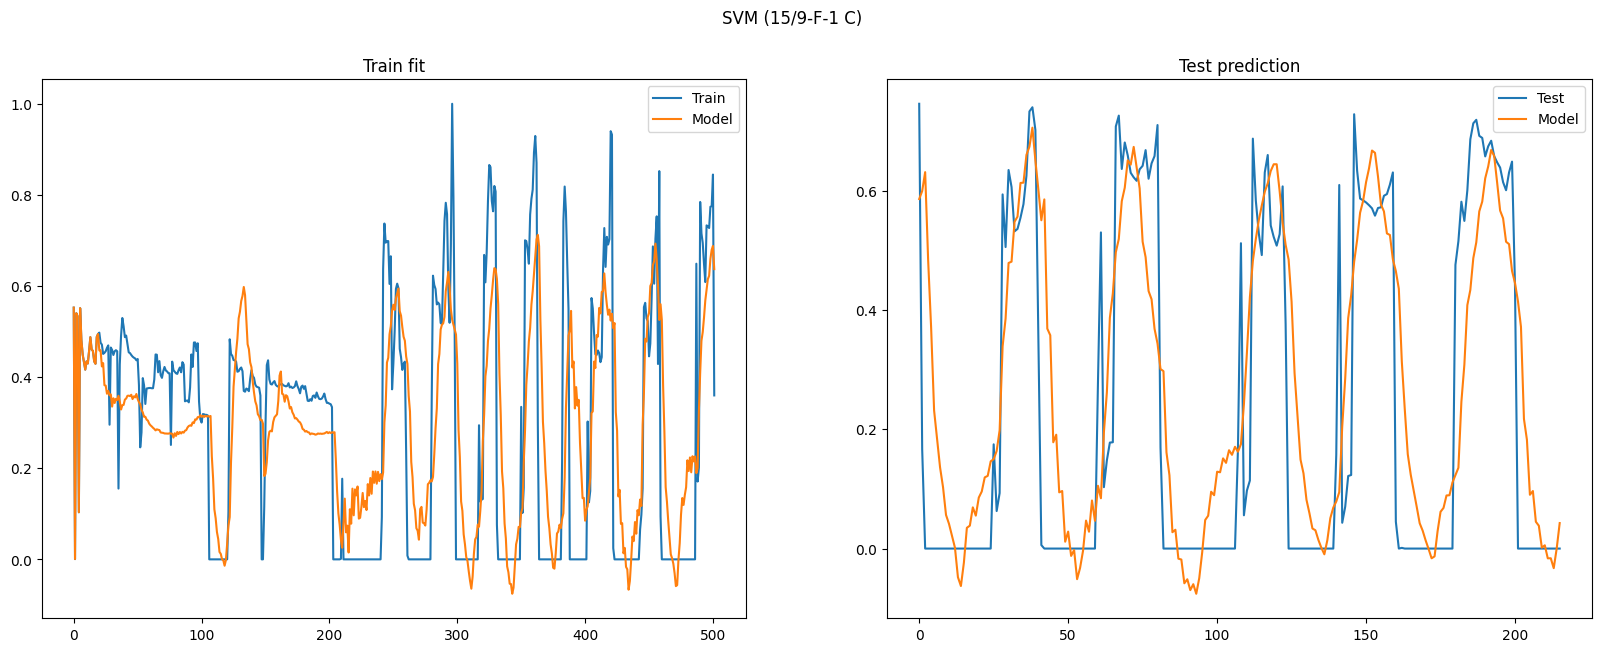

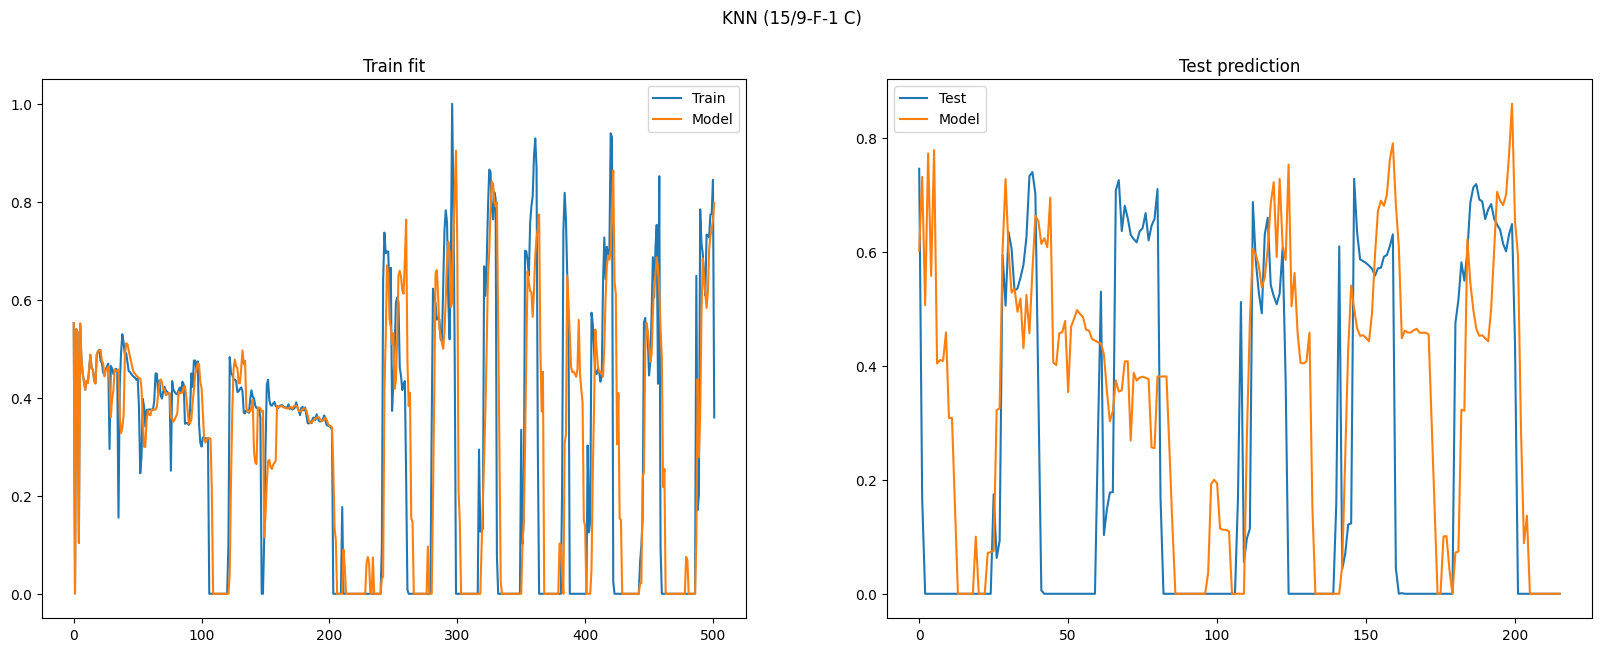

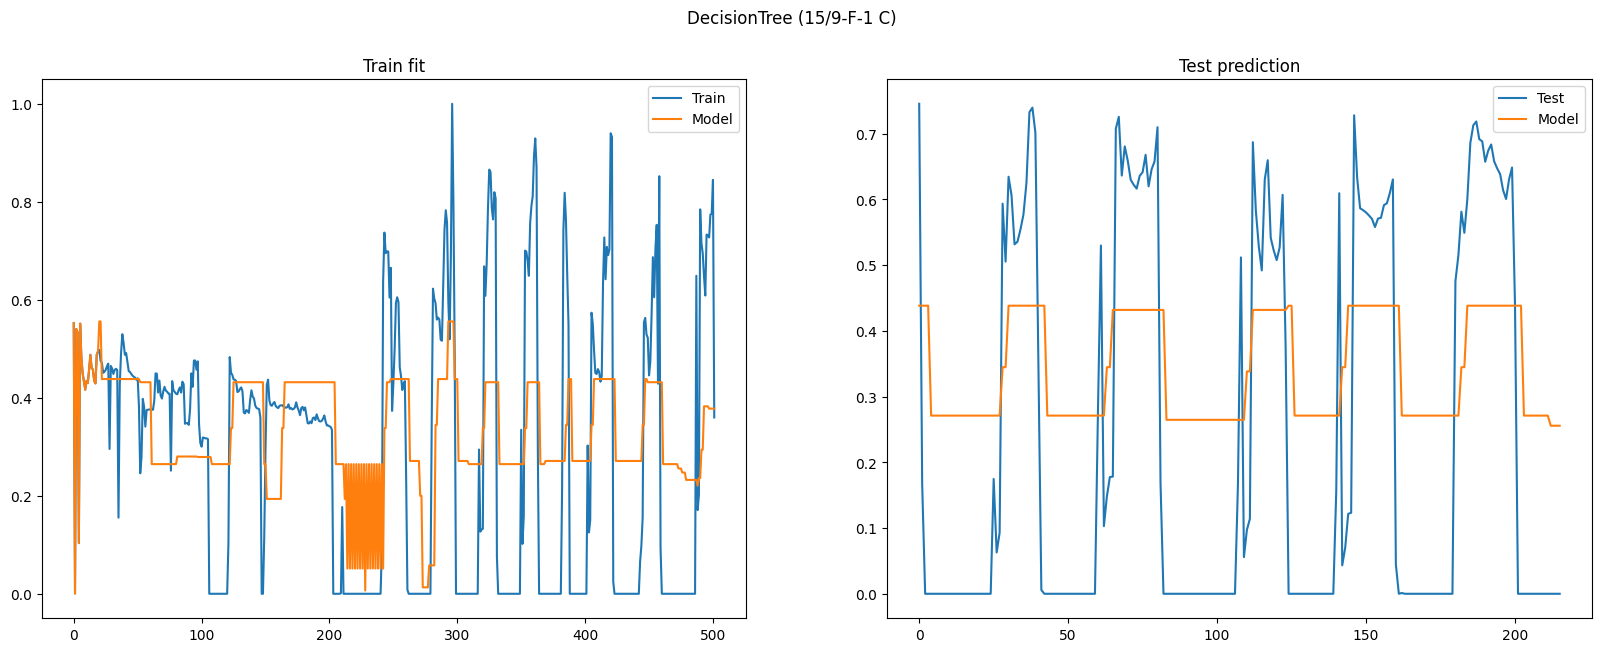

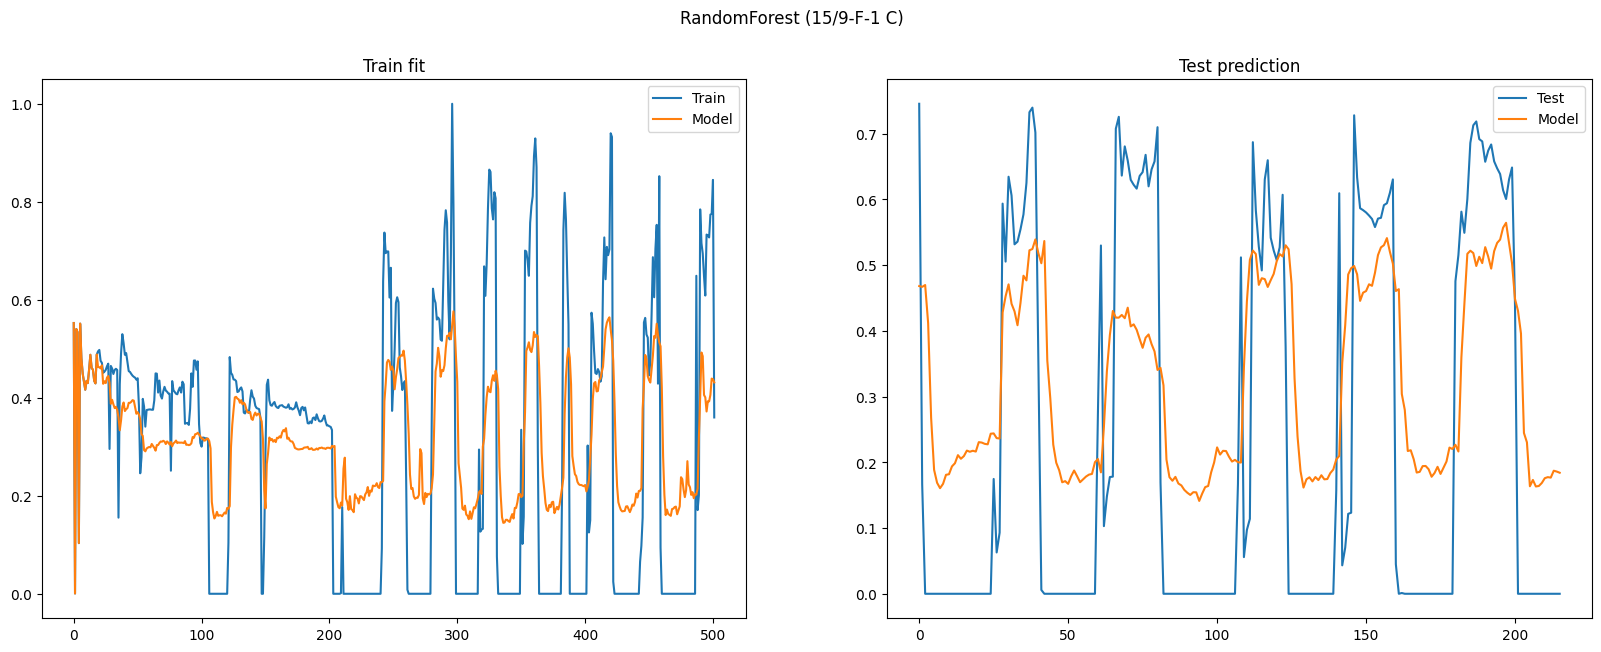

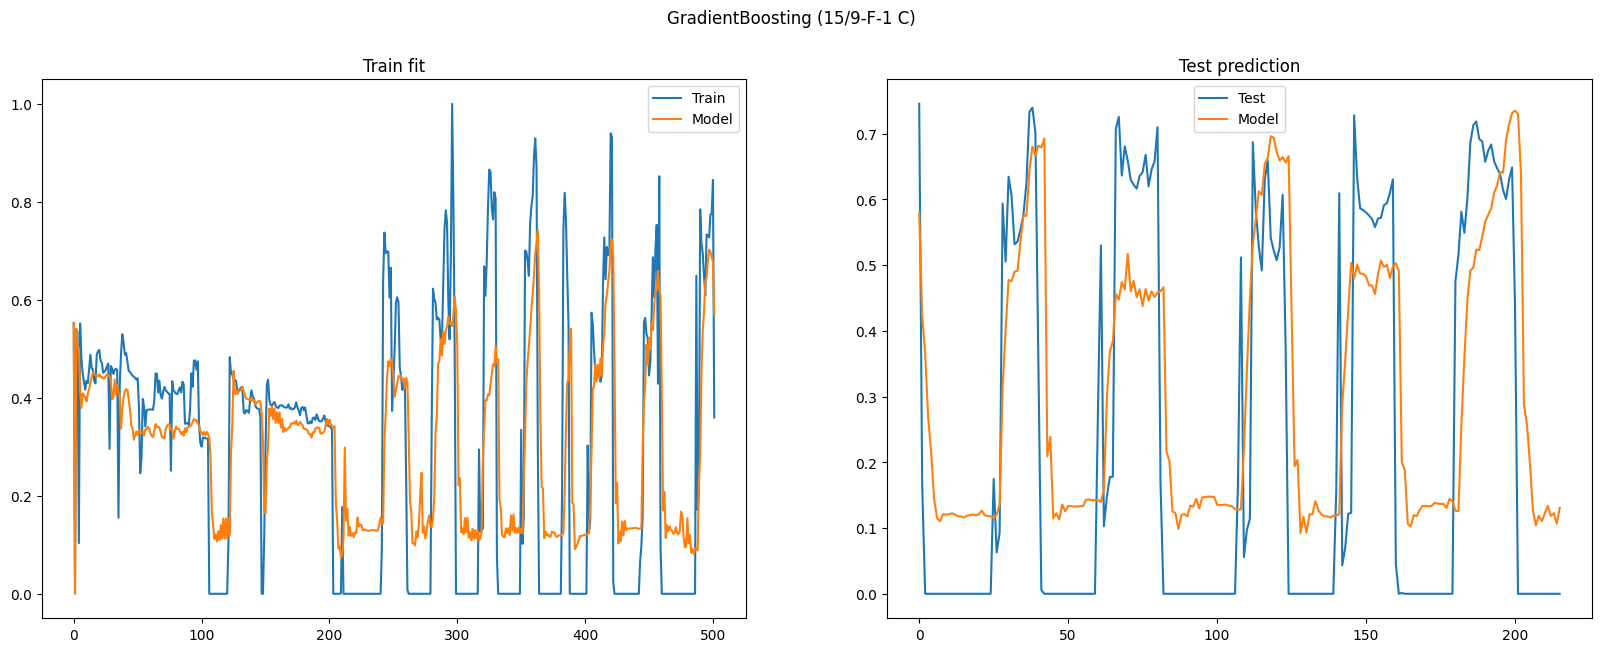

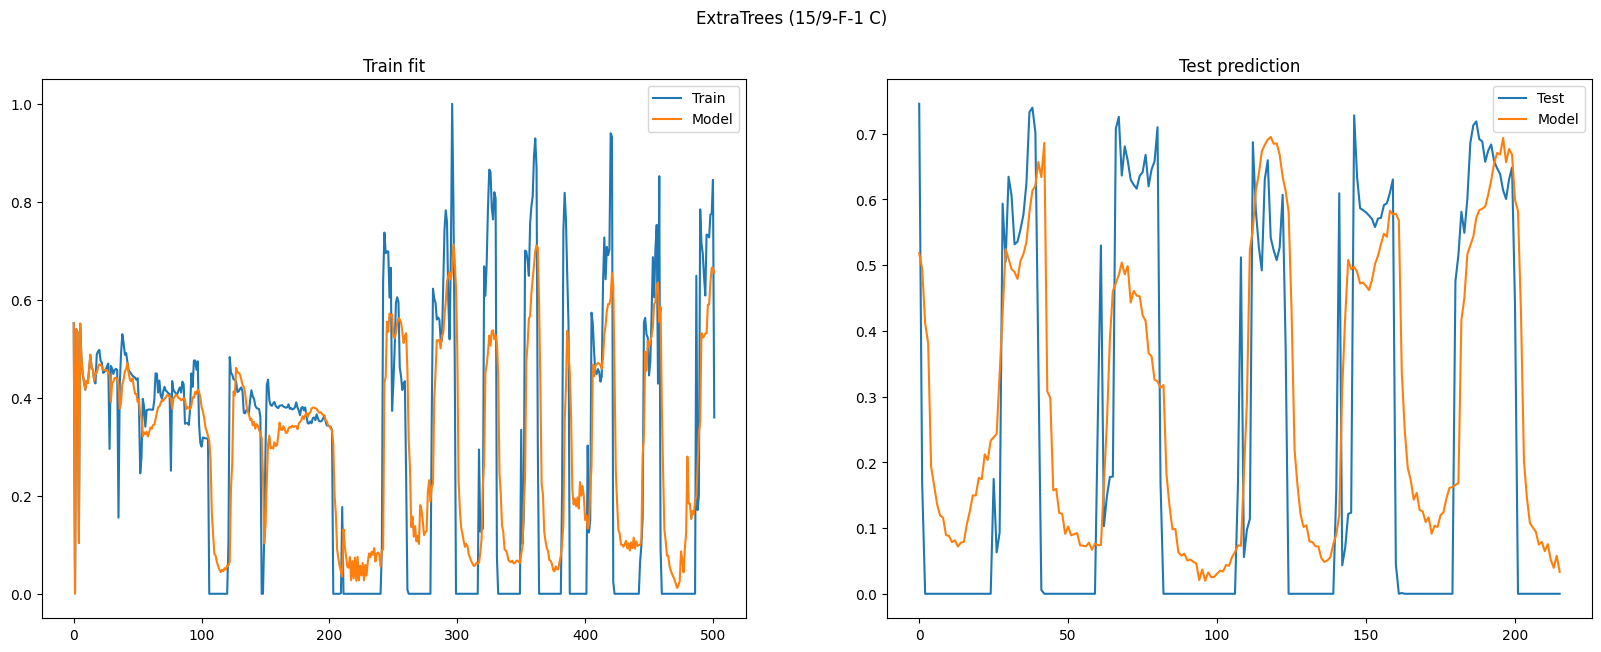

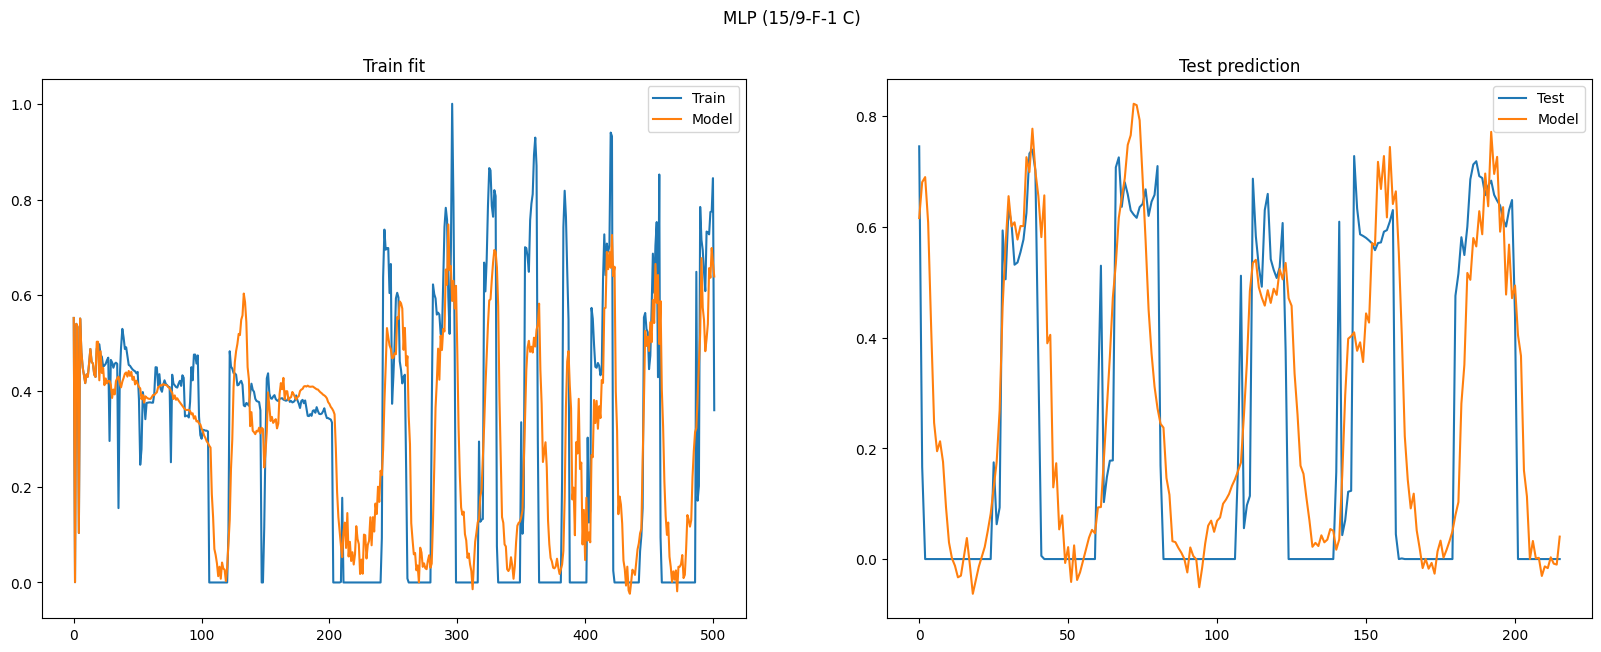

In [23]:

#fig, axs = plt.subplots(ncols=2, nrows=n_models, figsize=(25,n_models*7))
orders = range(2,21)
prefix = 'SISO-FFT.W1'
#Loop principal, iterando sobre as listas
for model in models[2:]:
    
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20,7))

    model_name, sidmodel = model

    print('Starting evaluation of model: {}'.format(model_name))
    
    t0 = datetime.now()

    best_r2_tr_fs = 1e6
    best_r2_te_fs = 1e6
    best_r2_tr_osa = 1e6
    best_r2_te_osa = 1e6
    best_order = 0
    best_model = sidmodel
    
    for order in orders:
        print(f'    Trying order: {order}')
        if hasattr(sidmodel, 'nX'): # is from our package
            sidmodel.nX = order
            sidmodel.ny = order
        else:
            sidmodel.xlag = [order]*X1_tr.shape[1]
            sidmodel.ylag = order
            sidmodel.elag = order
            regressors = regressor_code(X=X1_tr,
                                        xlag=[order]*X1_tr.shape[1],
                                        ylag=order,
                                        model_type="NARMAX",
                                        model_representation="neural_network",
                                        basis_function=sidmodel.basis_function
                                        )

            n_features = regressors.shape[0]
            
            #sidmodel.n_terms = n_features

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            sidmodel.fit(X=X1_tr, y=y_tr)
        r2_tr_osa = r2_score(y_tr.sum(axis=1), sidmodel.predict(X1_tr, y=y_tr, steps_ahead=1).sum(axis=1))
        r2_te_osa = r2_score(y_te.sum(axis=1), sidmodel.predict(X1_te, y=y_te, steps_ahead=1).sum(axis=1))
        try:
            r2_tr_fs = r2_score(y_tr.sum(axis=1), sidmodel.predict(X1_tr, y=y_tr).sum(axis=1))
            r2_te_fs = r2_score(y_te.sum(axis=1), sidmodel.predict(X1_te, y=y_te).sum(axis=1))
        except ValueError:
            r2_tr_fs = 1e290
            r2_te_fs = 1e290
        if np.abs(r2_tr_fs - 1) < np.abs(best_r2_tr_fs - 1):
            best_r2_tr_fs = r2_tr_fs
            best_r2_te_fs = r2_te_fs
            best_r2_tr_osa = r2_tr_osa
            best_r2_te_osa = r2_te_osa
            best_order = order
            best_model = copy.deepcopy(sidmodel)
        order_progression['MODEL'].append(model_name)
        order_progression['ORDER'].append(order)
        order_progression['R2 TRAIN OSA'].append(r2_tr_osa)
        order_progression['R2 TEST OSA'].append(r2_te_osa)
        order_progression['R2 TRAIN FS'].append(r2_tr_fs)
        order_progression['R2 TEST FS'].append(r2_te_fs)
        order_progression['MODEL OBJ'].append(copy.deepcopy(sidmodel))
        print('        R2 score OSA (Train):', r2_tr_osa)
        print('        R2 score OSA (Test):', r2_te_osa)
        print('        R2 score FS (Train):', r2_tr_fs)
        print('        R2 score FS (Test):', r2_te_fs)
    print()
    print('    Tempo de execução: {}'.format(datetime.now() - t0))
    print('    Best Order:', best_order)
    print('    R2 score OSA (Train):', best_r2_tr_osa)
    print('    R2 score OSA (Test):', best_r2_te_osa)
    print('    R2 score FS (Train):', best_r2_tr_fs)
    print('    R2 score FS (Test):', best_r2_te_fs)

    hist = ax[0].plot(y_tr.sum(axis=1), label='Train')
    hist = ax[0].plot(best_model.predict(X1_tr, y=y_tr).sum(axis=1), label='Model') 
    ax[0].set_title(f'Train fit')
    ax[0].legend()
    hist = ax[1].plot(y_te[n_train:,:].sum(axis=1), label='Test')
    hist = ax[1].plot(best_model.predict(X1_te, y=y_te)[n_train:,:].sum(axis=1), label='Model')
    ax[1].set_title(f'Test prediction')
    ax[1].legend()
    fig.suptitle(f'{model_name} ({case})')
    fig.savefig(os.path.join(os.getcwd(),'outputs', 'test_runs',f'{prefix}_{model_name}.pdf'))
    print()
    
    results['MODEL'].append(model_name) 
    results['ORDER'].append(best_order)
    results['R2 TRAIN OSA'].append(best_r2_tr_osa)
    results['R2 TEST OSA'].append(best_r2_te_osa)
    results['R2 TRAIN FS'].append(best_r2_tr_fs)
    results['R2 TEST FS'].append(best_r2_te_fs) 
    results['MODEL OBJ'].append(best_model)
    try:
        results['PARS'].append(None)
    except Exception:
        results['PARS'].append(best_model.final_model)

In [25]:
pd.DataFrame(results)

,MODEL,ORDER,R2 TRAIN OSA,R2 TEST OSA,R2 TRAIN FS,R2 TEST FS,MODEL OBJ,PARS
0,SVM,20,0.775938,0.772708,0.535752,0.569688,SYSIDRegressor(estimator=MultiOutputRegressor(...,None
1,KNN,19,1.000000,0.816461,0.533630,0.350107,SYSIDRegressor(estimator=MultiOutputRegressor(...,None
2,DecisionTree,20,0.823157,0.793370,0.280256,0.278423,SYSIDRegressor(estimator=MultiOutputRegressor(...,None
3,RandomForest,19,0.917520,0.853846,0.498840,0.487260,SYSIDRegressor(estimator=MultiOutputRegressor(...,None
4,GradientBoosting,3,0.876095,0.833641,0.583690,0.554790,SYSIDRegressor(estimator=MultiOutputRegressor(...,None
5,ExtraTrees,17,0.974281,0.882108,0.661023,0.623728,SYSIDRegressor(estimator=MultiOutputRegressor(...,None
6,MLP,18,0.893004,0.836972,0.601091,0.584846,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,None


In [26]:
order_progression = pd.DataFrame(order_progression)
order_progression

,MODEL,ORDER,R2 TRAIN OSA,R2 TEST OSA,R2 TRAIN FS,R2 TEST FS,MODEL OBJ
0,SVM,2,0.715462,0.722811,2.593925e-01,2.492235e-01,SYSIDRegressor(estimator=MultiOutputRegressor(...
1,SVM,3,0.729118,0.734419,2.862804e-01,2.766037e-01,SYSIDRegressor(estimator=MultiOutputRegressor(...
2,SVM,4,0.732454,0.735174,3.121472e-01,3.013153e-01,SYSIDRegressor(estimator=MultiOutputRegressor(...
3,LinReg,2,0.775574,0.777487,-9.783555e+203,-3.194801e+296,SYSIDRegressor(estimator=MultiOutputRegressor(...
4,LinReg,3,0.779406,0.780084,-inf,-inf,SYSIDRegressor(estimator=MultiOutputRegressor(...
...,...,...,...,...,...,...,...
137,MLP,16,0.867452,0.821602,5.673917e-01,5.580145e-01,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
138,MLP,17,0.899071,0.840900,5.087590e-01,5.231703e-01,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
139,MLP,18,0.893004,0.836972,6.010909e-01,5.848458e-01,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
140,MLP,19,0.975829,0.805502,5.677481e-01,4.319073e-01,SYSIDRegressor(estimator=RandomizedSearchCV(cv...


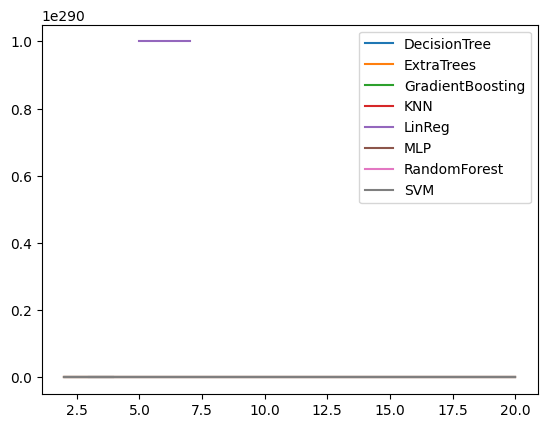

In [27]:
fig, ax = plt.subplots()
for model in np.unique(order_progression.MODEL):
    #if model == 'DT': continue
    data_filt = order_progression[order_progression.MODEL == model]
    data_filt = data_filt[data_filt['R2 TEST FS'] >= 0]
    ax.plot(data_filt.ORDER, data_filt['R2 TEST FS'], label=model)
ax.legend()

In [28]:

binary = os.path.join(os.getcwd(), 'outputs', 'test_runs', f'{prefix}_ml.pkl')
print(binary)

with open(binary, 'wb') as bin_file:
    pickle.dump((X1_tr, y_tr, X1_te, y_te, results, order_progression), bin_file)


/mnt/d/Onedrive/Mestrado/gits/sklearn-sid/Volve-Dataset/outputs/test_runs/SISO-FFT.W1_ml.pkl


In [29]:
print(results['PARS'][-1])

None
